In [ ]:
# 这是用RNN模型将sin的输入转换为cos的输出；
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
TIME_STEP = 9                               # rnn 定义的时间步数
INPUT_SIZE = 1                              # 因为输入的是1个数字，输入也就是1个feature
LR = 0.01                                   # learning rate
HIDDEN_SIZE = 64                            # 隐藏层的特征数量
torch.manual_seed(1)                        # 随机数种子

In [ ]:

class RNN(nn.Module):                                   # hidden = np.tanh(np.dot(self.W_hh, hidden) + np.dot(self.W_xh, x))
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(                              # 自己定义一个RNN神经网络
            input_size = INPUT_SIZE,                    # 输入 x 的feature 维度
            hidden_size = HIDDEN_SIZE,                  # 隐状态 hidden_state 中的feature维度
            num_layers = 5,                             # RNN 的层数
            nonlinearity='relu',                        # 指定激活函数 [‘tanh’ | ’relu’]. 默认: ‘tanh’
            bias = True,                                # 如果是 False , 那么 RNN 层就不会使用偏置权重 b_ih 和 b_hh, 默认: True
            batch_first = True,                         # 如果 True, 输入Tensor的shape应该是(batch, seq, features),并且输出也是一样.
            dropout = 0,                                # 如果值非零, 那么除了最后一层外, 其它层的输出都会套上一个 dropout 层
            bidirectional = False                       # 如果 True , 将会变成一个双向 RNN, 默认为 False
        )
        self.out = nn.Linear(HIDDEN_SIZE, 1)            # 定义一个输出层，这是RNN的最后输出，只用输出output_vector

    def forward(self, x, h_state):                      # 这就是RNN每次输入的参数x和h。RNN输入必需是3维tensor
        # x (batch, time_step, input_size)              # 这是RNN的ｘ的维度            (批量, 序列长度, 输入的特征维度）
        # h_state (n_layers, batch, hidden_size)        # 这是hidden_state的维度       (层数×方向, 批量, 输出的特征维度）/*方向：单向是１；双向是２*/
        # r_out (batch, time_step, hidden_size)         # 这是网络实际输出的r_out的维度 (批量，序列长度，输出的特征维度X方向）
        r_out, h_state = self.rnn(x, h_state)           # RNN每次输入x, hidden_state; 输出r_out, hidden_state; 给定一个序列x,每个x.size=[batch_size, feature].
        outs = []
        for time_step in range(r_out.size(1)):
            outs.append(self.out(r_out[:, time_step, :]))

        return torch.stack(outs, dim=1), h_state        # RNN的forward输出了output_vector, hidden_state

In [ ]:
rnn = RNN()
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR, weight_decay=1e-6)    # 定义了优化函数ADAM对RNN的参数反向优化，定义了 learning rate 和 权重衰减率
loss_func = nn.MSELoss()                                                    # 定义了模型的损失函数用 mean-square-error


h_state = None                                                          # 起始时输入给RNN的hidden_state就是None

for step in range(200):                                                # 计算２000次。相当于２000个顺序的时间片数据丢进去计算
    start, end = step*np.pi, (step+1)*np.pi                             # 每次计算的区间就是一个PI里的数据
    steps = np.linspace(start, end, TIME_STEP, dtype=np.float32)        # 在[star，star+PI]之间均匀地取TIME_STEP个点
    x_np = np.sin(steps)                                                # 这就是用来输入的数据。就是每个点的sin值
    y_np = np.cos(steps+np.pi/2)                                          # 这就是需要被预测出的数据。就是每个点的cos值
    
    x = Variable(torch.from_numpy(x_np[np.newaxis, :, np.newaxis]))     # 将x_np从1维(n)转化成3维(1,n,1);forward()里定义了x格式(batch, seq_len, input_size)
    y = Variable(torch.from_numpy(y_np[np.newaxis, :, np.newaxis]))     # 将y_np从1维(n)转化成3维(1,n,1);forward()里定义了out格式(batch, seq_len, input_size)
    # print(x.size())
    # print(y.size())
    
    prediction, h_state = rnn(x, h_state)                               # 这就是一次RNN模型forward()得出来的结果
    # print(h_state.size())                                             # h_state是tensor(data, grad_fn=xxxx)它的data格式为tensor(n_layers, batch, hidden_size)
    h_state = Variable(h_state.data)                                    # 把 h_state(tensor)中的数据取出来,因为h_state包含.data和.grad 舍弃了梯度

    loss = loss_func(prediction, y)                                     # 用损失函数计算误差
    optimizer.zero_grad()                                               # 清空优化器梯度
    loss.backward()                                                     # 反向传播求解梯度
    optimizer.step()                                                    # 更新权重的参数。优化网络参数具体应指 W_xh, W_hh, b_h 以及 W_hq, b_q
    
    if (step+1)%20==0:
        print("step:{}  loss:{:.9f}".format(step, loss.data.float()))

        plt.ion()                                                           # 把实际图和预测图动态打印出来
        plt.plot(steps, y_np, color='b')
        plt.plot(steps, np.squeeze(prediction.data.numpy()), color='r')
        plt.show()
        plt.pause(0.30)

In [ ]:
# 以下为新的 RNN 例子

In [ ]:
# 试一下 RNN 的变长seq的处理情况
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_sequence
from torch.nn.utils.rnn import pad_packed_sequence
from torch.nn.utils.rnn import pack_padded_sequence

In [ ]:
# 生成 3 句话
sa = [[1],[2],[3]]
sb = [[4], [5]]
sc = [[6]]

In [ ]:
# 再来定义一个RNN
rnn = nn.RNN(1, 3, batch_first=True)

In [ ]:
# 用rnn处理一下第一句话
input = torch.Tensor([sa])
rnn(input)

In [ ]:
# 把 sa,sb,sc 做成一个batch来处理
# 下面这样处理是错误的
# input = torch.Tensor([sa, sb, sc])
# 因为sa的dim是3，sb的dim是2，sc的dim是1，这不匹配
# [
#  [[1],[2],[3]],
#  [[4],[5]],
#  [[6]]
# ]
# 要把矩阵调整到一样维度的话，做补齐
# [
#  [[1],[2],[3]]
#  [[4],[5],[0]]
#  [[6],[0],[0]]
# ]

# 下面用 0 来补齐，并调整成 batch_first
padded_seq = pad_sequence([torch.Tensor(sa), torch.Tensor(sb), torch.Tensor(sc)], batch_first=True)
print(padded_seq)

# 如果不是 batch_first 的模式
# padded_seq = pad_sequence([torch.Tensor(sa), torch.Tensor(sb), torch.Tensor(sc)], batch_first=False)
# print(padded_seq)

rnn(padded_seq)

In [ ]:
# 或者不再补 0， 直接每次抽取一个元素后生成seq 后再发给RNN
packed_seq = pack_sequence([torch.Tensor(i) for i in [sa, sb, sc]])
print(packed_seq)
# 但是packed_seq默认是seq_first的，所以前面的rnn要重新来
rnn = nn.RNN(1, 3)
rnn(packed_seq)
                            

In [ ]:
################# 下面试试股票数据处理 #################

In [ ]:
import pandas as pd

In [ ]:
# 加载数据
dataset = pd.read_csv("000600.csv", index_col=0)
dataset = dataset.drop(['date','prediction'], axis=1)
# print(dataset.columns)
# print(dataset.tail())
dataset['updown'] = dataset['updown']
print(dataset.shape)
# print(dataset.tail())

In [ ]:
# 方法1，直接将数据等分成batch
# 把数据分成训练数据和测试数据
# print(dataset)
# n_train = 120
# train = dataset.iloc[:n_train, :].reset_index(drop=True)
# test  = dataset.iloc[n_train:, :].reset_index(drop=True)

# train_x, train_y = train.iloc[:, 1:], train.iloc[:, 0]
# test_x, test_y = test.iloc[:, 1:], test.iloc[:, 0]

# train_y = np.array(train_y).reshape(-1, 1)
# test_y = np.array(test_y).reshape(-1, 1)

# print(train_x.shape)
# print(train_y.shape)
# print(test_x.shape)
# print(test_y.shape)


In [ ]:
# 数据转换成 tesnsor
# train_x = torch.tensor(np.array(train_x))
# train_y = torch.tensor(np.array(train_y))
# test_x = torch.tensor(np.array(test_x))
# test_y = torch.tensor(np.array(test_y))
# print(train_x.shape)
# print(train_y.shape)
# print(test_x.shape)
# print(test_y.shape)

# # 数据转成 batch 的格式
# batch_count = 8               # 把训练数据切割成 batch_count 个batch
# batch_size = 15               # 每个batch里面有 batch_size 个数据

# # 把训练数据分成 8 个batch，每个 15 个数据
# train_x = train_x.reshape(batch_count, batch_size, 117)
# train_y = train_y.reshape(batch_count, batch_size, 1)
# # 把测试数据分成 2 个batch，每个 batch 有 15 个数据
# test_x = test_x.reshape(2, 15, 117)
# test_y = test_y.reshape(2, 15, 1)

In [480]:
# 方法2，将数据按照batch_size的窗口进行滑动，每个窗口数据做一组


rolling_data = pd.DataFrame()
for i in dataset.rolling(batch_size):
    if i.shape[0] == batch_size:
        rolling_data = rolling_data.append(i)
print(rolling_data.shape)                              # 所以一共有 136x15 组数据, 每一行的数据是118维 （包括y）batch_count * batch_size * dimi

# # 数据转成 batch 的格式
batch_size = 15                                        # 每个batch里面有 batch_size 组数据
batch_count = int(rolling_data.shape[0]/15)            # 把数据切割成 batch_count 个 batch

train_batch_count = 134
test_batch_count = batch_count - train_batch_count

train = rolling_data.iloc[:train_batch_count*batch_size, :].reset_index(drop=True)
test  = rolling_data.iloc[train_batch_count*batch_size:, :].reset_index(drop=True)

train_x, train_y = train.iloc[:, 1:], train.iloc[:, 0]
test_x, test_y = test.iloc[:, 1:], test.iloc[:, 0]

train_y = np.array(train_y).reshape(-1, 1)
test_y = np.array(test_y).reshape(-1, 1)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

# 数据转换成 tesnsor
train_x = torch.tensor(np.array(train_x))
train_y = torch.tensor(np.array(train_y))
test_x = torch.tensor(np.array(test_x))
test_y = torch.tensor(np.array(test_y))
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

# 把训练数据分成 8 个batch，每个 15 个数据
train_x = train_x.reshape(train_batch_count, batch_size, 117)
train_y = train_y.reshape(train_batch_count, batch_size, 1)
# 把测试数据分成 2 个batch，每个 batch 有 15 个数据
test_x = test_x.reshape(test_batch_count, batch_size, 117)
test_y = test_y.reshape(test_batch_count, batch_size, 1)

(2040, 118)
(2010, 117)
(2010, 1)
(30, 117)
(30, 1)
torch.Size([2010, 117])
torch.Size([2010, 1])
torch.Size([30, 117])
torch.Size([30, 1])


In [481]:
# 开始定义 RNN 模型
TIME_STEP = 15
INPUT_SIZE = 117
HIDDEN_SIZE = 512

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        
        self.rnn = nn.RNN(
                input_size = INPUT_SIZE,                    # 输入 x 的feature 维度
                hidden_size = HIDDEN_SIZE,                  # 隐状态 hidden_state 中的feature维度
                num_layers = 1,                             # RNN 的层数
                nonlinearity='relu',                        # 指定激活函数 [‘tanh’ | ’relu’]. 默认: ‘tanh’
                bias = True,                                # 如果是 False , 那么 RNN 层就不会使用偏置权重 b_ih 和 b_hh, 默认: True
                batch_first = True,                         # 如果 True, 输入Tensor的shape应该是(batch, seq, features),并且输出也是一样.
                dropout = 0,                                # 如果值非零, 那么除了最后一层外, 其它层的输出都会套上一个 dropout 层
                bidirectional = False                       # 如果 True , 将会变成一个双向 RNN, 默认为 False
        )
        self.out = nn.Linear(HIDDEN_SIZE, 1)
        
    def forward(self, x, h_state):
        r_out, h_state = self.rnn(x, h_state)
        outs = []
        for time_step in range(TIME_STEP):
            outs.append(self.out(r_out[:, time_step, :]))

        return torch.stack(outs, dim=1), h_state
    

In [482]:
# 初始化 RNN 模型
rnn = RNN()
LR = 5e-5
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR, weight_decay=5e-7)

i = 0
h_state = None

# 训练 RNN 模型
for step in range(100):
    i = i+1
    rnn = rnn.double()
    pred, h_state = rnn(train_x, h_state)
    h_state = h_state.data
    loss = loss_func(pred, train_y)
    if (i+1)%10 == 0:
        print(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

tensor(0.0011, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.0006, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.0004, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.0002, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.0002, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.0001, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.0001, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(9.1808e-05, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(7.7908e-05, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(6.7315e-05, dtype=torch.float64, grad_fn=<MseLossBackward0>)


tensor(0.0002, dtype=torch.float64, grad_fn=<MseLossBackward0>)


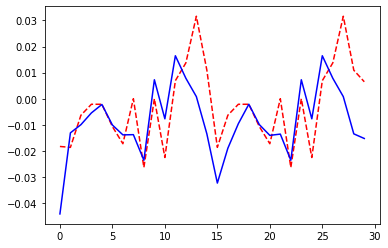

tensor([[-0.0323],
        [-0.0190],
        [-0.0096],
        [-0.0021],
        [-0.0099],
        [-0.0140],
        [-0.0136],
        [-0.0236],
        [ 0.0073],
        [-0.0077],
        [ 0.0165],
        [ 0.0078],
        [ 0.0008],
        [-0.0135],
        [-0.0152]], dtype=torch.float64, grad_fn=<SelectBackward0>)


In [487]:
# 用模型来做测试数据的误差
h_state = None
pred, h_state = rnn(test_x, h_state)
loss = loss_func(pred, test_y)
print(loss)
# print(pred)
actual_line = np.array(test_y).flatten().tolist()
pred_line = pred.data.numpy().flatten()
# print(test_x.shape)
num = list(range(test_x.shape[0] * test_x.shape[1]))
plt.plot(num, actual_line, 'r--')
plt.plot(num, pred_line, 'b-')
plt.draw()
plt.show()
print(pred[-1])